# Scaling Simulation Duration, Delay, and Cores

- Scale Duration configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/scale-length/parsplice-hr4)]
- Scale Delay configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-delay-100000-60117/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-delay-100000-60117/scale-delay/parsplice-d100K)]
- Scale Cores configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-tasks-64-59958/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-tasks-64-59958/scale-workers/parsplice-t64)]

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

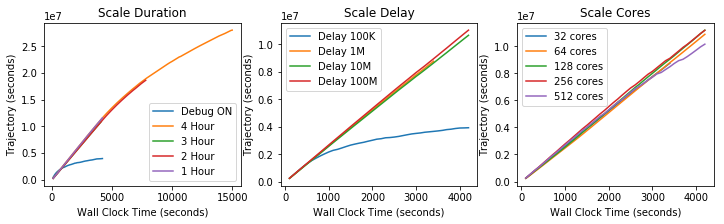

In [2]:
RAW_DF   = 0
COUNT_DF = 1
rank_names = {"00": "Splicer", "01": "Worker", "02": "PersistentDB", "03": "InMemoryDB", "04": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.out")
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label)
    ax.set_ylabel("Trajectory (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
d = "../experiments/baseline-trinitite/"
ax[0].set_title("Scale Duration")
plot_times(ax[0], "Debug ON",  d+"nano/delay100K/")
plot_times(ax[0], "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971")
plot_times(ax[0], "3 Hour", d+"nano/parmsweep/scale-length-hr3-59970")
plot_times(ax[0], "2 Hour", d+"nano/parmsweep/scale-length-hr2-59969")
plot_times(ax[0], "1 Hour", d+"nano/parmsweep/scale-length-hr1-59968")

ax[1].set_title("Scale Delay")
plot_times(ax[1], "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117")
plot_times(ax[1], "Delay 1M", d+"nano/parmsweep/scale-delay-1000000-60120")
plot_times(ax[1], "Delay 10M", d+"nano/parmsweep/scale-delay-10000000-60119")
plot_times(ax[1], "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118")

ax[2].set_title("Scale Cores")
plot_times(ax[2], "32 cores",  d+"nano/parmsweep/scale-delay-1000000-60120")
plot_times(ax[2], "64 cores",  d+"nano/parmsweep/scale-tasks-64-59958")
plot_times(ax[2], "128 cores", d+"nano/parmsweep/scale-tasks-128-59959")
plot_times(ax[2], "256 cores", d+"nano/parmsweep/scale-tasks-256-59962")
plot_times(ax[2], "512 cores", d+"nano/parmsweep/scale-tasks-512-59963")

In [3]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971"))
stats.append(parse(dfs, "3 Hour", d+"nano/parmsweep/scale-length-hr3-59970"))
stats.append(parse(dfs, "2 Hour", d+"nano/parmsweep/scale-length-hr2-59969"))
stats.append(parse(dfs, "1 Hour", d+"nano/parmsweep/scale-length-hr1-59968"))
stats.append(parse(dfs, "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117"))
stats.append(parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120"))
stats.append(parse(dfs, "Delay 10M",  d+"nano/parmsweep/scale-delay-10000000-60119"))
stats.append(parse(dfs, "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118"))

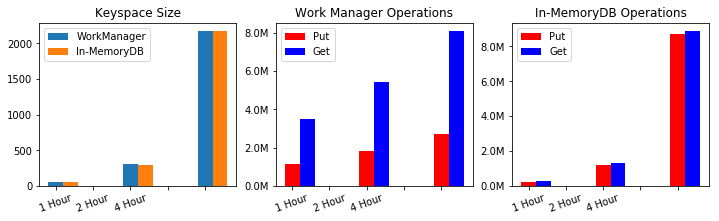

In [4]:
def plot_keyspace(key_names):
    def get_keys(op, rank):
        ret = []
        for name in key_names:
            ret.append((name, op, rank))
        return ret
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].set_title("Keyspace Size")
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "4")],
              label="WorkManager", width=0.2)
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "3"))) + 0.2,
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "3")],
              label="In-MemoryDB", width=0.2)
    
    ax[1].set_title("Work Manager Operations")
    ax[1].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryPut", "4")],
              label="Put", width=0.2, color='red')
    ax[1].bar(np.arange(len(get_keys("DBMemoryGet", "4"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryGet", "4")],
              label="Get", width=0.2, color='blue')
    ax[1].set_yticklabels(['{:3.1f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    ax[2].set_title("In-MemoryDB Operations")
    ax[2].bar(np.arange(len(get_keys("DBMemoryPut", "3"))),
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryPut", "3")],
              label="Put", width=0.2, color='red')
    ax[2].bar(np.arange(len(get_keys("DBMemoryGet", "3"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryGet", "3")],
              label="Get", width=0.2, color='blue')
    ax[2].set_yticklabels(['{:3.1f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    for a in range(0, len(ax)):
        ax[a].set_xticklabels([0] + [k[0] for k in get_keys("DBMemoryPut", "4")], rotation=20)
        ax[a].legend()

plot_keyspace(["1 Hour", "2 Hour", "4 Hour"])

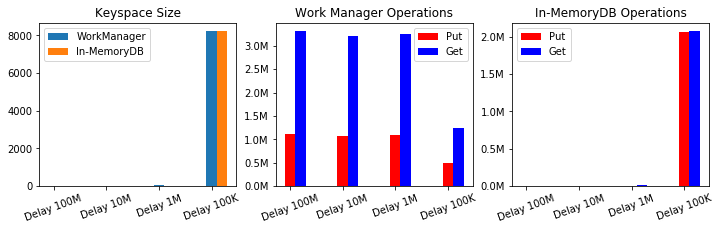

In [5]:
plot_keyspace(["Delay 100M", "Delay 10M", "Delay 1M", "Delay 100K"])

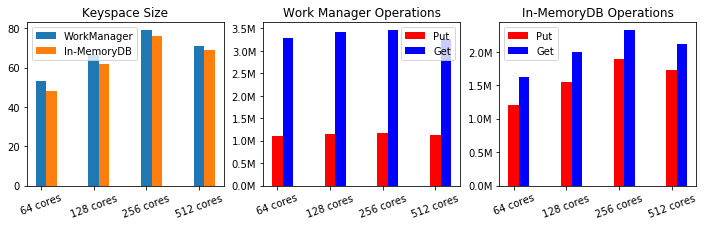

In [6]:
dfs = {}
stats.append(parse(dfs, "64 cores",  d+"nano/parmsweep/scale-tasks-64-59958"))
stats.append(parse(dfs, "128 cores", d+"nano/parmsweep/scale-tasks-128-59959"))
stats.append(parse(dfs, "256 cores", d+"nano/parmsweep/scale-tasks-256-59962"))
stats.append(parse(dfs, "512 cores", d+"nano/parmsweep/scale-tasks-512-59963"))
stats.append(plot_keyspace(["64 cores", "128 cores", "256 cores", "512 cores"]))

In [8]:
stats

[['4 Hour DBMemoryPut Splicer: nkeys=51, hottest key=10313986423432176915 (count=1)',
  '4 Hour DBMemoryGet Splicer: nkeys=51, hottest key=13397889897772269455 (count=2)',
  '4 Hour DBMemoryPut InMemoryDB: nkeys=2173, hottest key=10002327738147764502 (count=1)',
  '4 Hour DBMemoryGet InMemoryDB: nkeys=2173, hottest key=10313986423432176915 (count=2)',
  '4 Hour DBMemoryPut WorkManager: nkeys=2178, hottest key=14045287823504495930 (count=100092)',
  '4 Hour DBMemoryGet WorkManager: nkeys=2193, hottest key=14045287823504495930 (count=300219)'],
 ['3 Hour DBMemoryPut Splicer: nkeys=16, hottest key=11669211761296708093 (count=1)',
  '3 Hour DBMemoryGet Splicer: nkeys=16, hottest key=13397889897772269455 (count=2)',
  '3 Hour DBMemoryPut InMemoryDB: nkeys=46, hottest key=10709269897150474038 (count=1)',
  '3 Hour DBMemoryGet InMemoryDB: nkeys=46, hottest key=11669211761296708093 (count=2)',
  '3 Hour DBMemoryPut WorkManager: nkeys=56, hottest key=1736974060065875077 (count=1922214)',
  '3 H

In [81]:
parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120")
parse(dfs, "Delay 100K",   d+"nano/parmsweep/scale-delay-100000-60117")

['Delay 100K DBMemoryPut Splicer: nkeys=71, hottest key=10396159671373412358 (count=1)',
 'Delay 100K DBMemoryGet Splicer: nkeys=71, hottest key=13397889897772269455 (count=2)',
 'Delay 100K DBMemoryPut InMemoryDB: nkeys=8238, hottest key=10000949668668174214 (count=1)',
 'Delay 100K DBMemoryGet InMemoryDB: nkeys=8238, hottest key=10396159671373412358 (count=2)',
 'Delay 100K DBMemoryPut WorkManager: nkeys=8244, hottest key=16222664147866608531 (count=10119)',
 'Delay 100K DBMemoryGet WorkManager: nkeys=8244, hottest key=13397889897772269455 (count=30210)']

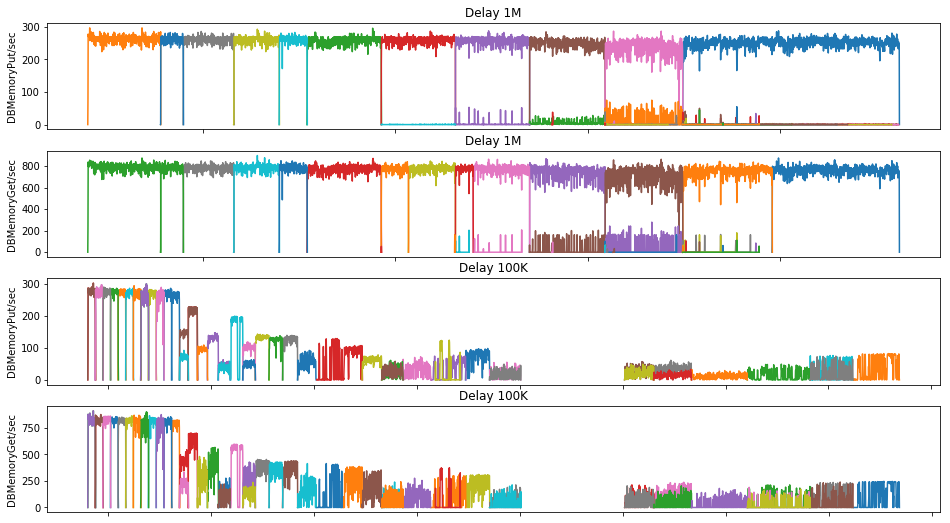

In [83]:
def plot_keytimes(ax, dfs, key, shift=0, nkeys=50):
    topKeys = dfs[key]['DF_KEY_COUNT'].nlargest(nkeys, 'count').head(nkeys)
    for k in topKeys['key']:
        raw = dfs[key]['DF_KEY_TIMES']
        df = raw[(raw['key'] ==  k)]
        if len(df) == 0:
            continue
        df = df.groupby('ts').size().reset_index()
        df.columns=['ts', 'count']
        
        first    = np.min(df['ts']) - 1
        ts_range = np.max(df['ts']) - first + 2
        x = np.arange(ts_range) + first
        y = np.zeros(ts_range)
        for k, v in df.iterrows():
            y[v['ts'] - first] = v['count']
        ax.plot(x, y, label=key)
    ax.set_xticklabels([])
    ax.set_title(key[0])
    ax.set_ylabel(key[1] + "/sec")